# Прогноз оттока клиентов.

**Цели и задачи исследования:**
- провести исследовательский анализ данных;
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    -  выделить целевые группы клиентов;
    -  предложить меры по снижению оттока;
    -  определить другие особенности взаимодействия с клиентами.

**Описание данных:**

Данные клиента за предыдущий до проверки факта оттока месяц:
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент - — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- `Churn` — факт оттока в текущем месяце.

## Загрузка библиотек, открытие файла с данными.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')
df.shape
df.info()
print("Количество дубликатов: {:.0f}".format(df.duplicated().sum()))
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


Таблица имеет 4000 строк, дубликаты отсутствуют. Для удобства приведем названия столбцов к нижнему регистру. 

In [3]:
df.columns = df.columns.str.lower()
df.head(5)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


## Исследовательский анализ данных.

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


In [5]:
print(df['gender'].value_counts())
print()
print(df['near_location'].value_counts())
print()
print(df['partner'].value_counts())
print()
print(df['promo_friends'].value_counts())
print()
print(df['phone'].value_counts())
print()
print(df['contract_period'].value_counts())
print()
print(df['group_visits'].value_counts())
print()
print(df['age'].describe())
print()
print(df['avg_additional_charges_total'].describe())
print()
print(df['month_to_end_contract'].describe())
print()
print(df['lifetime'].describe())
print()
print(df['avg_class_frequency_total'].describe())
print()
print(df['avg_class_frequency_current_month'].describe())
print()
print(df['churn'].value_counts())

1    2041
0    1959
Name: gender, dtype: int64

1    3381
0     619
Name: near_location, dtype: int64

0    2053
1    1947
Name: partner, dtype: int64

0    2766
1    1234
Name: promo_friends, dtype: int64

1    3614
0     386
Name: phone, dtype: int64

1     2207
12     960
6      833
Name: contract_period, dtype: int64

0    2351
1    1649
Name: group_visits, dtype: int64

count    4000.000000
mean       29.184250
std         3.258367
min        18.000000
25%        27.000000
50%        29.000000
75%        31.000000
max        41.000000
Name: age, dtype: float64

count    4000.000000
mean      146.943728
std        96.355602
min         0.148205
25%        68.868830
50%       136.220159
75%       210.949625
max       552.590740
Name: avg_additional_charges_total, dtype: float64

count    4000.000000
mean        4.322750
std         4.191297
min         1.000000
25%         1.000000
50%         1.000000
75%         6.000000
max        12.000000
Name: month_to_end_contract, dtype: flo

В результате первоначального ознакомления с таблицей можно сделать выводы:
- пол клиентов представлен примерно одинаково: 2041 и 1959;
- клиентами фитнес-центра являются люди в возрасте от 18 до 41 года, средний возраст составляет 29 лет;
- суммарная выручка от других услуг фитнес-центра от 0.15 до 552.60, в среднем 146.9;
- средняя частота посещений от 0 до 6 раз в неделю, в среднем - 1.87;
- средний срок окончания действующего абонемента (в месяцах) - 4;
- среднее время с момента первого обращения в фитнес-центр(в месяцах) - 3.7. 

Выдающихся (аномальных) значений не обнаружено.

### Средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался. 

In [6]:
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


- пол килентов никак не влияет на отток, соотношение все также около 50/50;
- чаще остаются клиенты, являющиеся сотрудниками компаний-партнеров, участвующие в программе "приведи друга", имеющие абонемент в среднем на 5.7 месяцев, посещающие групповые занятия, приносящие больше выручки от других услуг фитнес-центра, посещающие занятия в среднем дважды в неделю;
- средний возраст оставшихся клиентов почти 30 лет;
- средний возраст ушедших около 27.

По столбцу `contact_period` (длительность текущего действущего абонемента) можно сделать вывод, что постоянными клиентами клуба становятся люди, купившие абонемент на срок больше 1 месяца. 

### Построение столбчатых гистограмм и распределения признаков для тех, кто ушёл и тех, кто остался.

In [7]:
#создадим два списка с количественными и категориальными переменными

counted=['age', 'lifetime', 'contract_period', 'avg_additional_charges_total',
       'month_to_end_contract', 'avg_class_frequency_total', 'avg_class_frequency_current_month']


category=['gender','near_location', 'partner', 'promo_friends','phone', 'group_visits']

#для нагрядности переименуем значения из столбца факта оттока
df1=df
df1=df1.replace({'churn':{0:'остался', 1:'ушел'}})

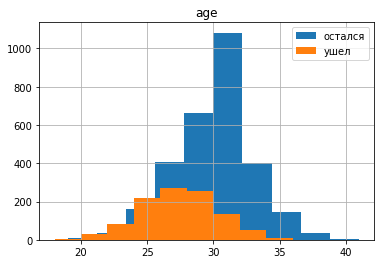

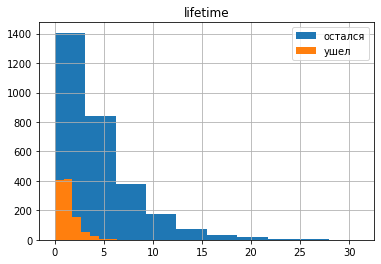

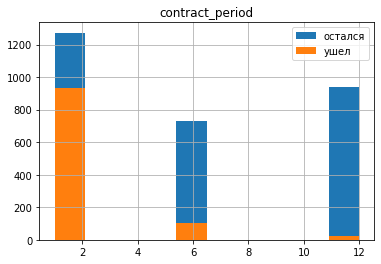

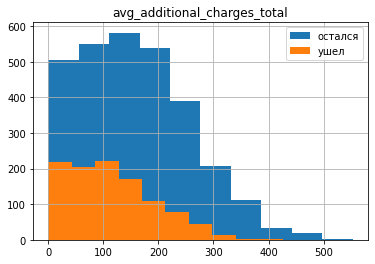

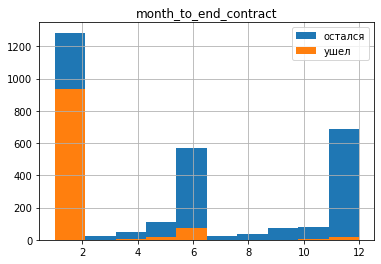

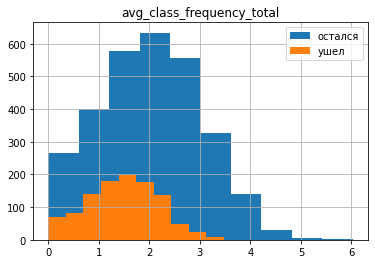

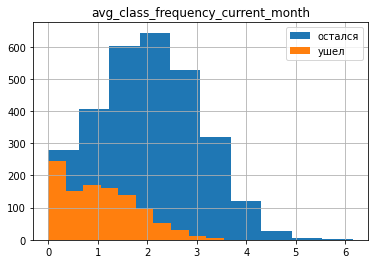

In [8]:
for i in counted:
    df1.groupby('churn')[i].hist()
    plt.legend(df1['churn'].unique())
    plt.title(i)
    plt.show()

Гистограммы показывают, что чаще всего уходят люди в возрасте около 26 лет, имеющие длительность абонемента в 1 месяц. 

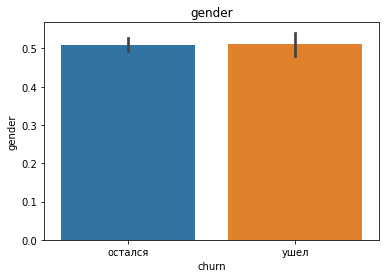

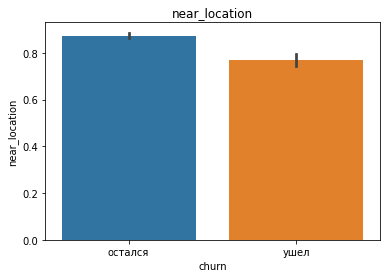

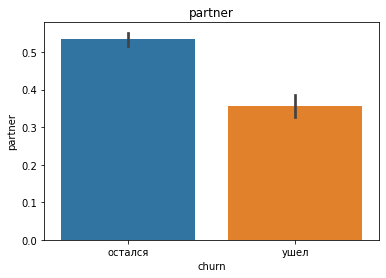

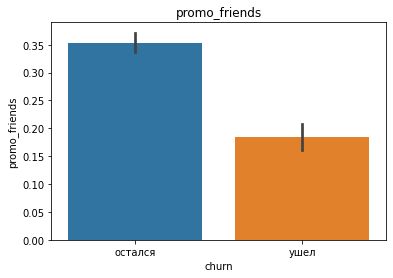

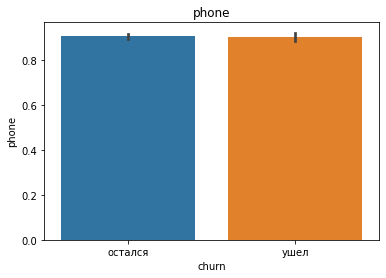

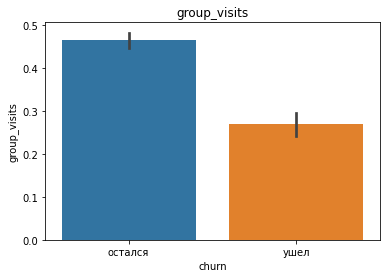

In [9]:
for i in category:
    sns.barplot(data=df1, x='churn', y=i)
    plt.title(i)
    plt.show()

По графикам может сделать вывод, что чаще остаются клиенты, живущие в районе, где находится фитнес-центр, являющиеся сотрудниками компании-партнёра клуба, пришедшие по акции "приведи друга" и посещающие групповые занятия. 

<div class="alert alert-success">

**✔️ Комментарий ревьюера**
    
Эстетичные визуализации и качественный анализ классов 👍🏻

### Матрица корреляций.

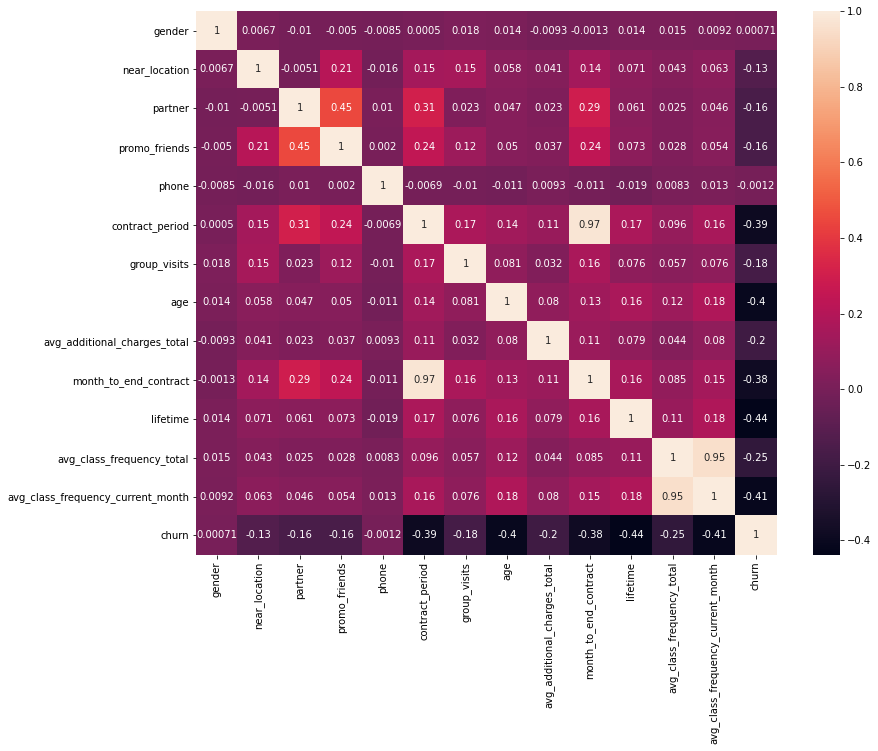

In [10]:
#построим и отрисуем матрицу корреляций
cm = df.corr()
fig, ax = plt.subplots(figsize=(13, 10))

#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot=True) 
plt.show()

Наибольшую корреляцию имеют `срок до окончания текущего действующего абонемента`  и `длительность текущего действующего абонемента` , `средняя частота посещений в неделю за все время с начала действия абонемента` (0.97) и ` средняя частота посещений в неделю за предыдущий месяц` (0.95)

Также наблюдается связь между `сотрудник компании-партнёра клуба` и `факт первоначальной записи в рамках акции «приведи друга»`. Учитывая привелегии для сотрудников, это выглядит вполне логично. Сотрудники компаний могут вместе ходить на тренировки со своими коллегами. 

## Модель прогнозирования оттока клиентов.

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

In [11]:
# функция вывода всех метрик
def print_all_metrics(y_true, y_pred, title):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [12]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('churn', axis=1)
y = df['churn'] 

In [13]:
#деление данных на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Логистическая регрессия

In [14]:
# задаем алгоритм
model = LogisticRegression(solver='liblinear', random_state=0)

In [15]:
# обучаем модель
model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [16]:
# прогноз
prediction = model.predict(X_test)

In [17]:
# выведим все метрики для логистической регрессии
print_all_metrics(y_test, prediction, 'Логистическая регрессия')

Логистическая регрессия
	Accuracy: 0.93
	Precision: 0.86
	Recall: 0.83


### Случайный лес

In [18]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)

In [19]:
# обучим модель случайного леса
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [20]:
# прогноз
rf_predictions = rf_model.predict(X_test)

In [21]:
# выведим все метрики для полученного прогноза
print_all_metrics(y_test, rf_predictions, 'Случайный лес')

Случайный лес
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.82


Исходя из сравнения метрик обеих моделей, можем сделать вывод, что наиболее подходящая модель - логистическая регрессия.

## Кластеризация клиентов.

In [22]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

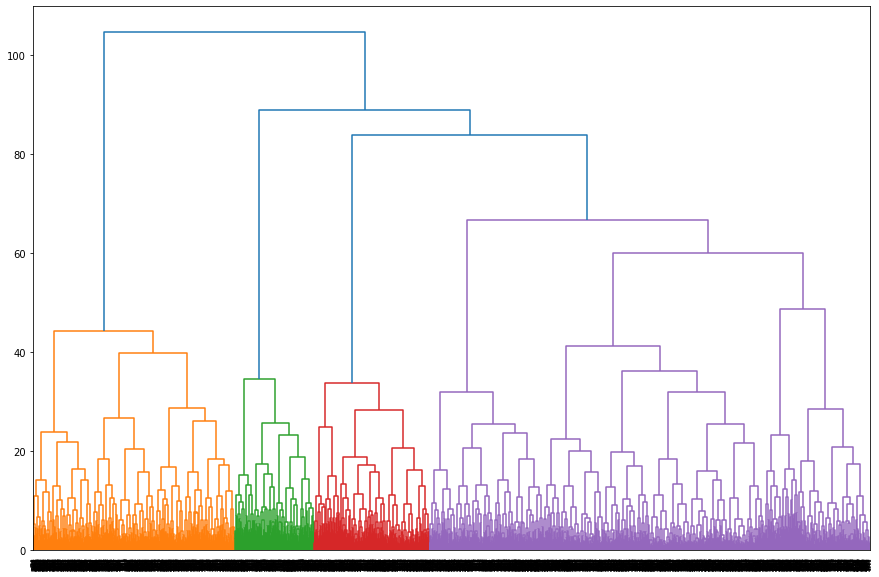

In [23]:
#построим матрицу расстояний и дендрограмму
linked = linkage(X_sc, method = 'ward') 

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show() 

Судя по дендограмме, можем выделить 4-5 кластеров. По заданию примем значение кластеров равным 5. 

In [24]:
# задаём модель k_means с числом кластеров 5
km = KMeans(n_clusters = 5, random_state=0)

# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

# сохраняем метки кластера
df['cluster'] = labels

In [25]:
df['cluster'].value_counts()

3    1262
0    1010
4     838
2     505
1     385
Name: cluster, dtype: int64

В кластер 0 попали `1010` клиентов, в кластер 1 - `385`, во второй - `505`, в третий `1262`, в четвертый - `838`. 

### Средние значения признаков для кластеров

In [26]:
df.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


- Сразу бросается в глаза, что в кластер 1 попали только клиенты, не оставившие свои телефонные номера;
- В кластер 2 попали только клиенты, проживающие или работающие вне района, где находится фитнес-центр;
- В кластер 4 - самые активные клиенты фитнес-центра, среднее количество посещений в неделю - 2.85, наименее активные - в кластере 3 - всего 1.2 посещений в неделю за все время с начала действия абонемента;
- В кластерах 0 и 4 самая высокая суммарная выручка от других услуг фитнес-центра и самая низкая вероятность оттока, можно сделать вывод, что в них попали самые лояльные клиенты фитнес-центра;
- Также в кластер 0 попали клиенты, длительность текущего действующего абонемента которых равен 10.88 (абонемент на 12 месяцев), чаще остальных приходящие по акции "пригласи друга", являющиеся партнерами клуба и посещающие групповые занятия.

### Распределение признаков для кластеров. 

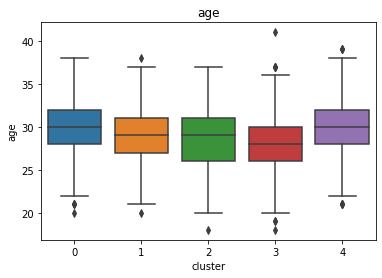

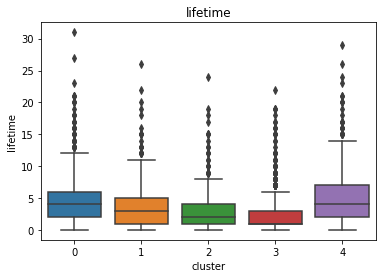

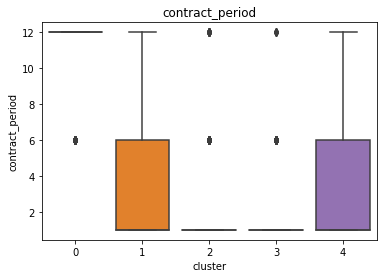

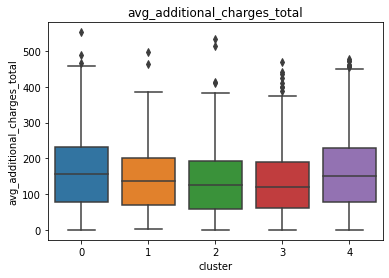

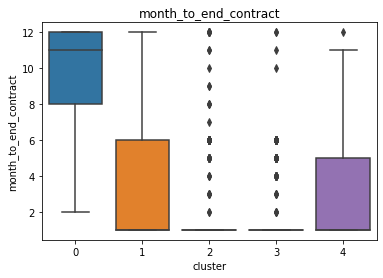

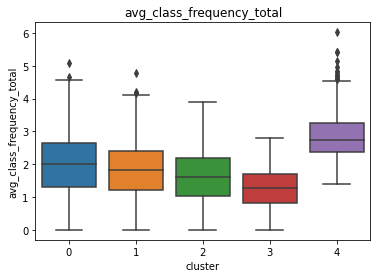

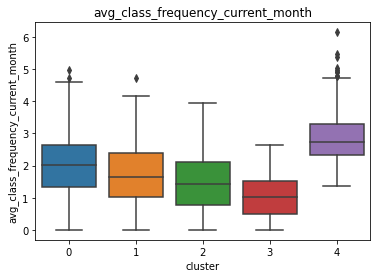

In [30]:
for i in counted:
    #df.groupby('cluster')[i].hist(alpha=0.4)
    sns.boxplot(x ='cluster',y = i, data = df)
    #plt.legend(df['cluster'].unique())
    plt.title(i)
    plt.show()

- В кластере 4 большинство клиентов возрастом от 25 до 28 лет, хотя средние значения в всех кластеров примерно одинаковые (29 лет);
- Также в 4 кластере самое малый лайфтайм: время с первого обращения в фитнес-центр;
- Кластер 1 состоит преимущественно из клиентов, покупающих абонемент на год;
- По суммарной выручке от других услуг фитнес-центра снова выделяется кластер 4;
- А по среднему посещению впереди всех - кластер 2.

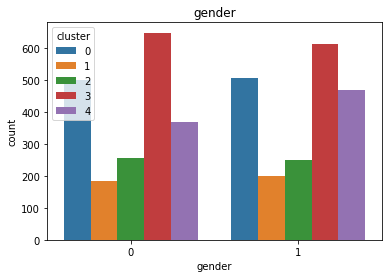

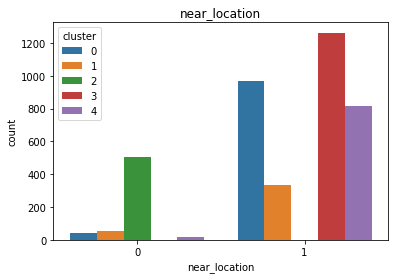

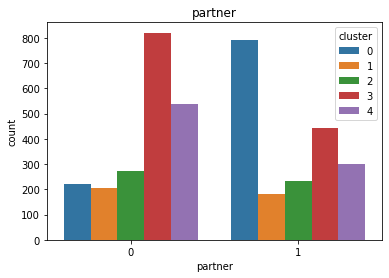

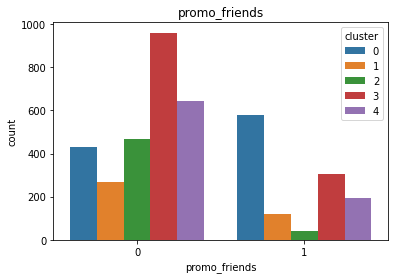

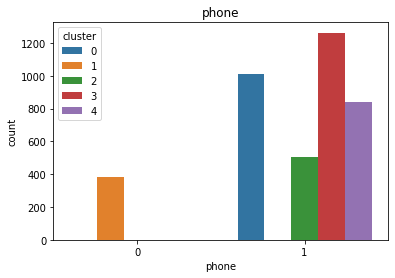

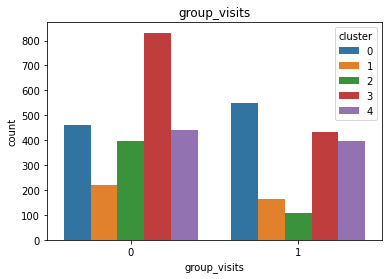

In [31]:
for i in category:
    sns.countplot(data = df, x = i, hue = 'cluster')
    plt.title(i)
    plt.show()

- Пол клиентов распределен примерно равномерно у всех кластеров;
- Как говорилось выше, в кластере 2 только клиенты, проживающие или работающие за пределами района, в котором находится фитнес-центр, а в кластере 1 - только клиенты, не оставившие свой номер телефона;
- Кластер 1 является лидером по количеству сотрудников компаний-партнеров клуба и использованию акции "приведи друга";
- Посещение групповых тренировок наиболее характерно для кластера 0 и 4. 

### Доля оттока для каждого кластера.

In [39]:
#df_clusters = df.query('churn==1').groupby('cluster')['churn'].count() / df['churn'].count()
#df_clusters
print(df.groupby('cluster')['churn'].mean())
#0.027723	0.267532	0.443564	0.514263	0.068019

cluster
0    0.027723
1    0.267532
2    0.443564
3    0.514263
4    0.068019
Name: churn, dtype: float64


Самые надеждные кластеры - 0 и 4, склонные к оттоку 3 и 2.

## Вывод и базовые рекомендации.

- По всем метрикам лучше себя показала модель логистической регрессии;
- Исходные данные были разделены на 5 кластеров;
- Самыми надеждными кластерами являются кластеры 0 и 4, склонные к оттоку - 3 и 2;
- Клиенты из надеждных кластеров характеризуются:
    - большой длительностью действующего абонемента;
    - проживанием или работой в районе, где находится фитнес-центр;
    - возраст в среднем 29 лет;
    - посещением фитнес-центра от двух раз в неделю;
    - посещением групповых тренировок;
    - приходящие по акции "приведи друга" и являющиеся сотрудниками компаний-партнеров фитнес-центра. 
    
Исходя из этого можно выделить следующие рекомендации: 
- привлекать новых клиентов, предлагая акции или партнерские программы;
- предлагать клиентам участие в групповых занятиях;
- предлагать новым клиентам скидки на абонементы скором 12 месяцев;